### CNN Model to Trace Diabetic Retinopathy

In [1]:
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil
import math
import sys
import gc

from tqdm import tqdm

gc.enable()

print(os.listdir(r"C:\Users\Sarmita Majumdar\Desktop\HealthCare-Research\aptos2019\Classification"))

['.ipynb_checkpoints', 'Diabetic-Retinopathy-CNN-Model.ipynb', 'diabetic_ret.csv', 'labels.csv', 'test.csv', 'test_images', 'train.csv', 'trainLabels.csv', 'train_images']


In [2]:
from tensorflow.compat.v1 import enable_eager_execution
from tensorflow.keras.layers import Concatenate, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [4]:
from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from tqdm import tqdm

In [5]:
gc.enable()

In [6]:
SEED = 7

dir_path = r'C:\Users\Sarmita Majumdar\Desktop\HealthCare-Research\aptos2019\Classification'
np.random.seed(SEED)
IMG_DIM = 299  # 224 399 #
BATCH_SIZE = 12
CHANNEL_SIZE = 3
NUM_EPOCHS = 60
TRAIN_DIR = 'train_images'
TEST_DIR = 'test_images'
FREEZE_LAYERS = 2  # freeze the first this many layers for training
CLASSES = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}

In [7]:
# Loading Data
df_train = pd.read_csv(os.path.join(dir_path, "train.csv"))
df_test = pd.read_csv(os.path.join(dir_path, "test.csv"))
NUM_CLASSES = df_train['diagnosis'].nunique()

In [8]:
print("Training set has {} samples and {} classes.".format(df_train.shape[0], df_train.shape[1]))
print("Testing set has {} samples and {} classes.".format(df_test.shape[0], df_test.shape[1]))

Training set has 3662 samples and 2 classes.
Testing set has 1928 samples and 1 classes.


##### Data Visualization and EDA
Data distrubution per class

as per below bar chart, it clearly showing that data set is quite imbalance. And even it's expected in medical domain.

In [9]:
# Plot the barchart
import seaborn as sns

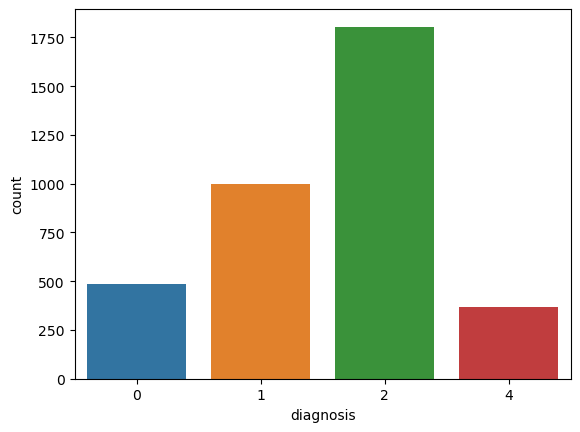

In [10]:

p = sns.countplot(df_train['diagnosis'], x = df_train['diagnosis'])

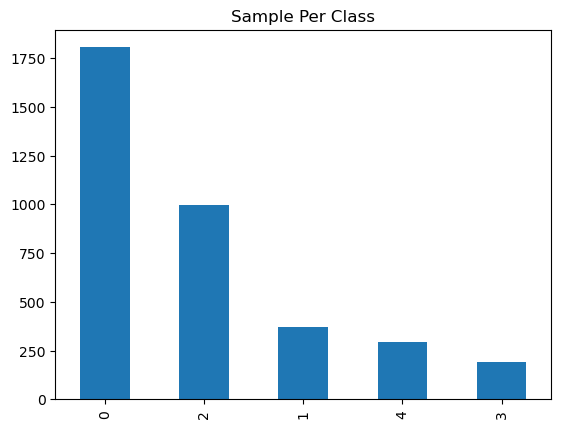

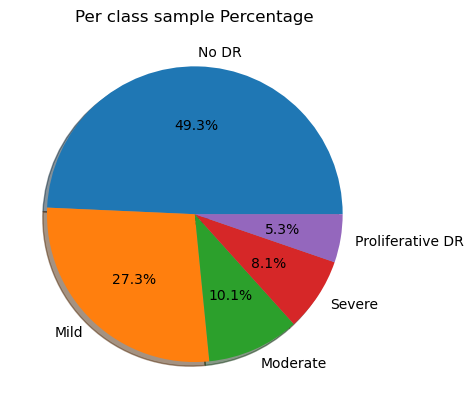

In [11]:
chat_data = df_train.diagnosis.value_counts()
chat_data.plot(kind='bar');
plt.title('Sample Per Class');
plt.show()
plt.pie(chat_data, autopct='%1.1f%%', shadow=True, labels=["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])
plt.title('Per class sample Percentage');
plt.show()

##### Train and Test dataset¶
We will use pie chart for showing the size of dataset.

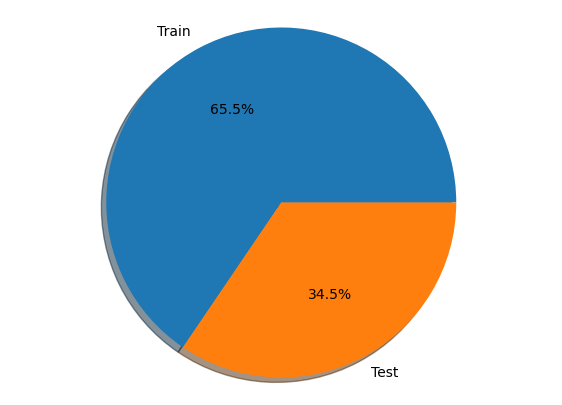

In [12]:
# Train & Test samples ratio
# Plot Data
labels = 'Train', 'Test'
sizes = df_train.shape[0], df_test.shape[0]
colors = 'lightskyblue', 'lightcoral'
# Plot
plt.figure(figsize=(7, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

In [13]:
#Split DataSet
x_train, x_test, y_train, y_test = train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2,
                                                    random_state=SEED, stratify=df_train.diagnosis)

In [14]:
import os
import cv2

In [15]:
### Data visualization is a process in AI, which will give you better insight of data.

def draw_img(imgs, target_dir, class_label='0'):
    fig, axis = plt.subplots(2, 6, figsize=(15, 6))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join(dir_path, f"{target_dir}/{row['id_code']}.png")
        img = cv2.imread(imgPath)
        row = idnx // 6
        col = idnx % 6
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis[row, col].imshow(img)
    plt.suptitle(class_label)
    plt.show()

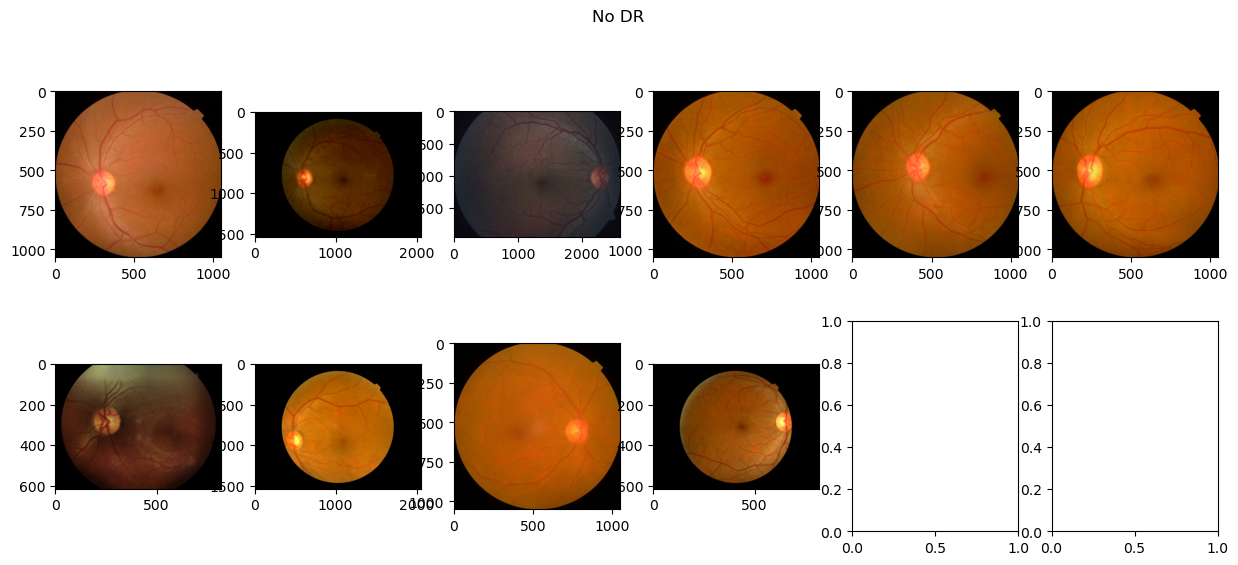

In [16]:
CLASS_ID = 0
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(10), 'train_images', CLASSES[CLASS_ID])

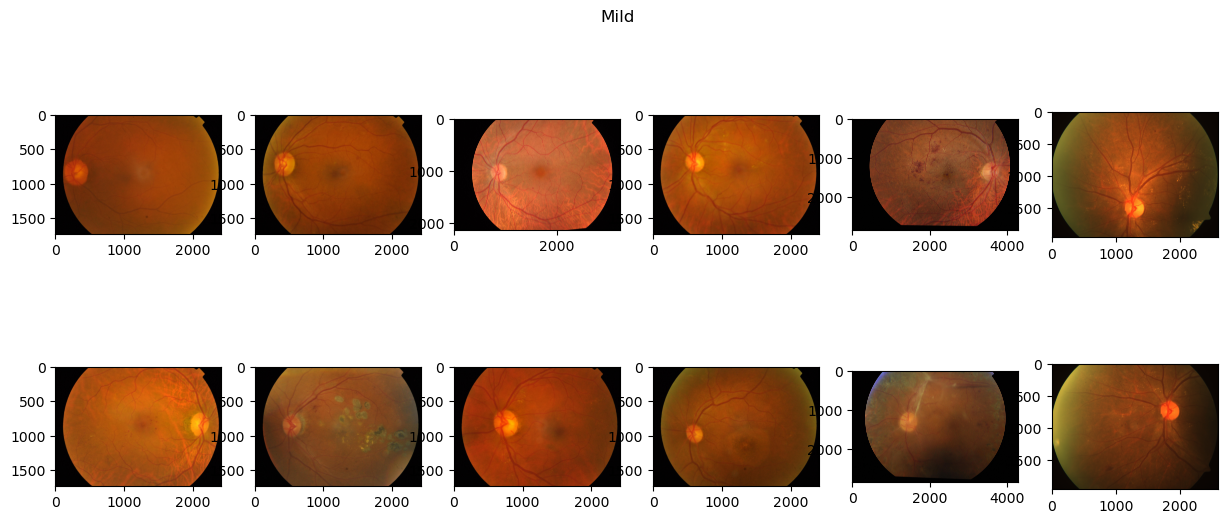

In [17]:
CLASS_ID = 1
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSES[CLASS_ID])

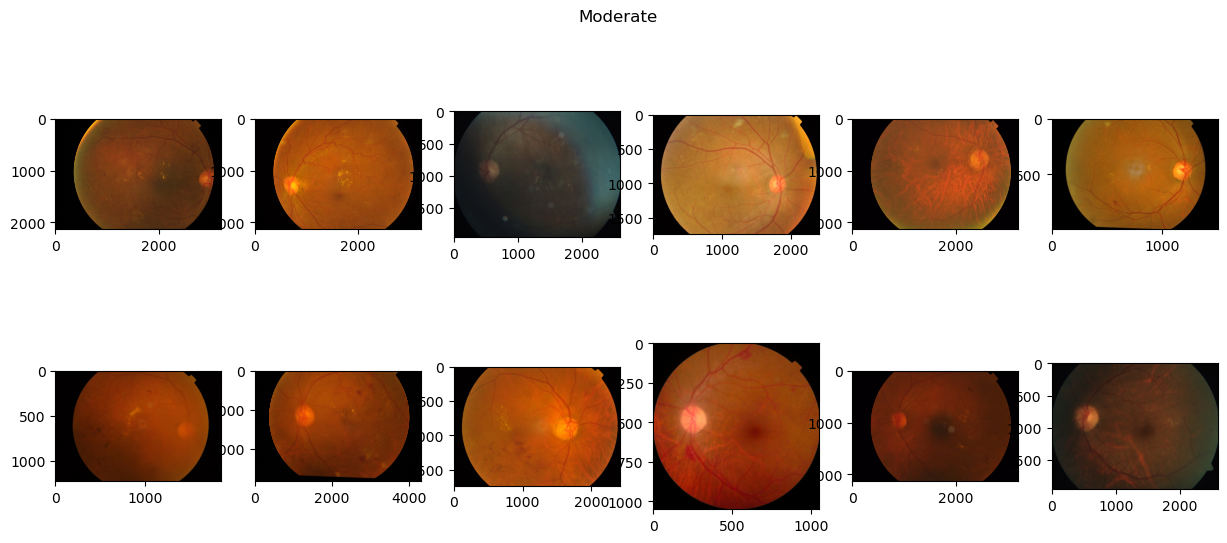

In [18]:
CLASS_ID = 2
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSES[CLASS_ID])

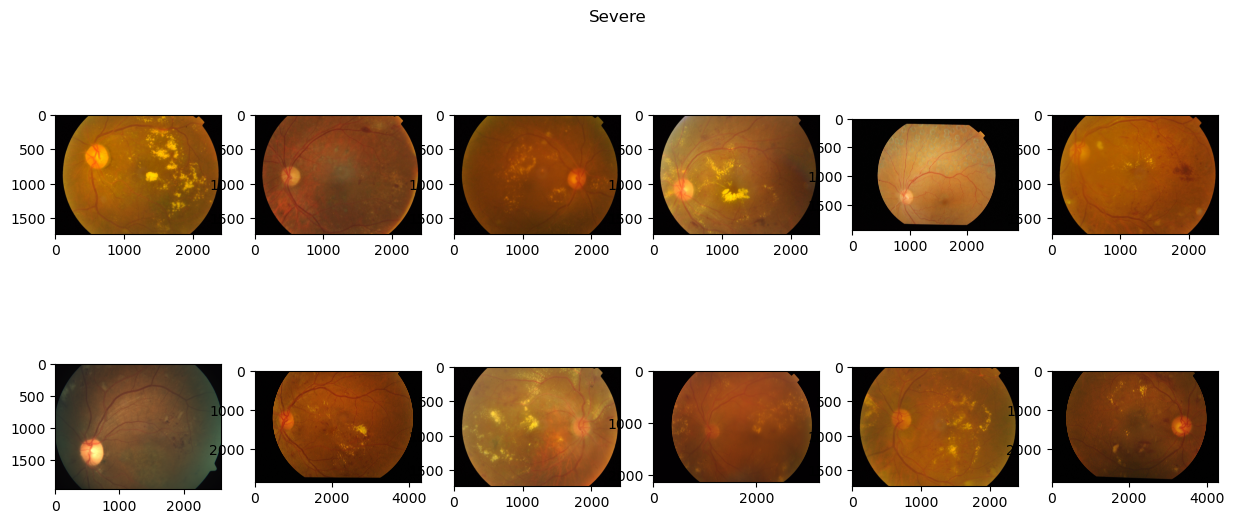

In [19]:
CLASS_ID = 3
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSES[CLASS_ID])

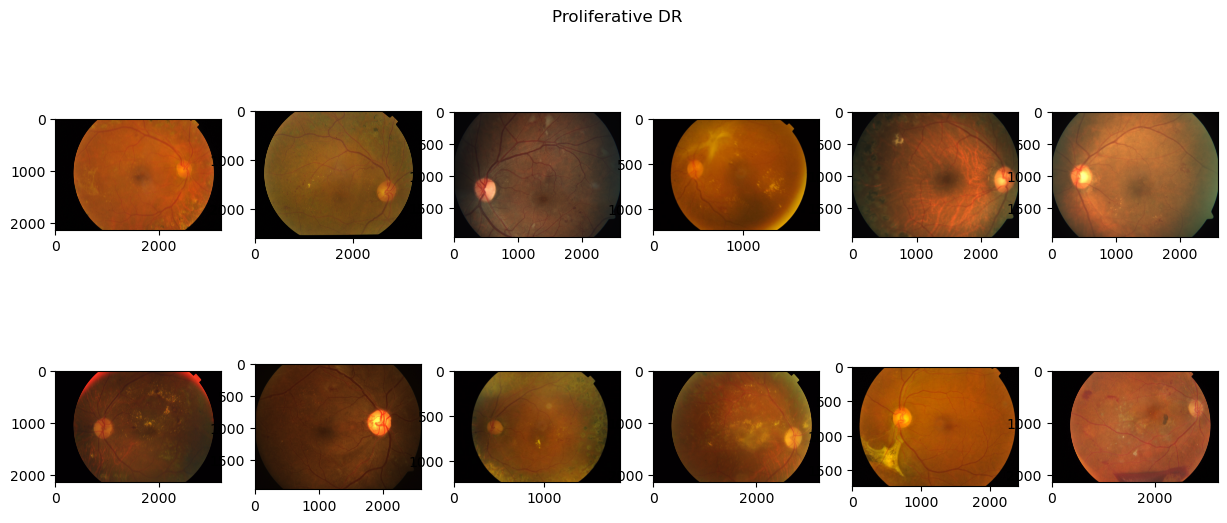

In [20]:
CLASS_ID = 4
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSES[CLASS_ID])

#### Sample images of dataset.

As we can see the image shape is not in standard shape, we need to resize data set image.
Some images are very small, and some are very large they are not in same standard.
Some are having large black area like image Proliferative[1,2] has lot of black area. Which is not relevant for your problem? May we would be requiring doing the image cropping.
Some image light is very dark.

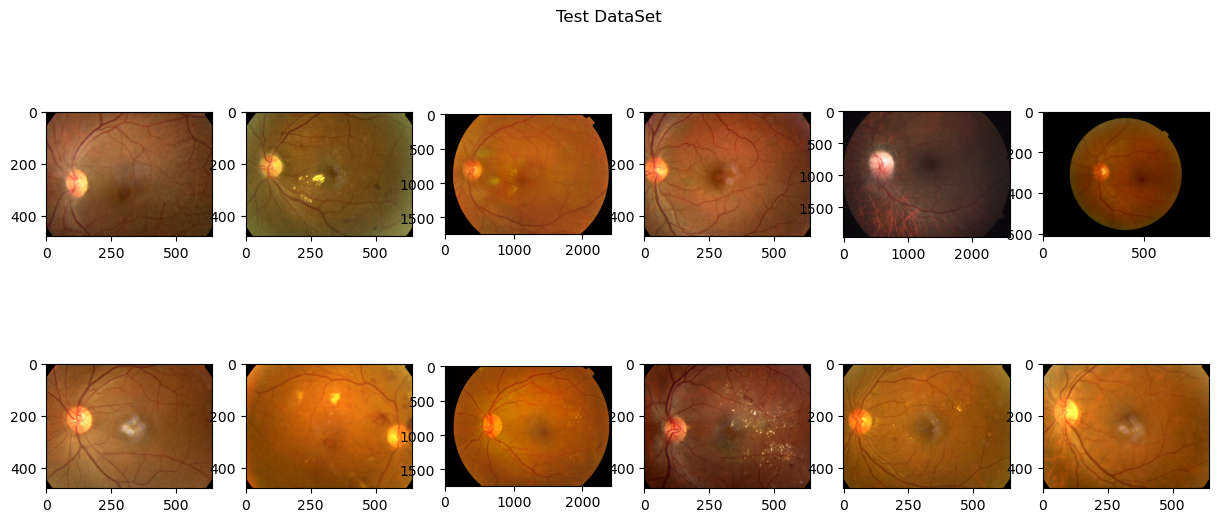

In [21]:
CLASS_ID = 'Test DataSet'
draw_img(df_test.sample(12, random_state=SEED), 'test_images', CLASS_ID)

In [22]:
def check_max_min_img_height_width(df, img_dir):
    max_Height , max_Width =0 ,0
    min_Height , min_Width =sys.maxsize ,sys.maxsize 
    for idx, row in df.iterrows():
        imgPath=os.path.join(dir_path,f"{img_dir}/{row['id_code']}.png") 
        img=cv2.imread(imgPath)
        H,W=img.shape[:2]
        max_Height=max(H,max_Height)
        max_Width =max(W,max_Width)
        min_Height=min(H,min_Height)
        min_Width =min(W,min_Width)
    return max_Height, max_Width, min_Height, min_Width

In [23]:
check_max_min_img_height_width(df_train, TRAIN_DIR)

(2848, 4288, 358, 474)

In [24]:
check_max_min_img_height_width(df_test, TEST_DIR)

(1958, 2896, 480, 640)

#### GrayScale Images
Converting the Ratina Images into Grayscale. So, we can usnderstand the regin or intest .

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


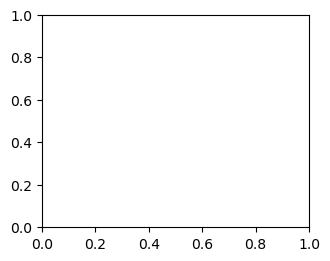

In [26]:
# Display some random images from Data Set with class categories in gray
figure = plt.figure(figsize=(20, 16))
for target_class in (y_train.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train.diagnosis == target_class].sample(5, random_state=SEED).iterrows()):
        ax = figure.add_subplot(5, 5, target_class * 5 + i + 1)
        imagefile = f"../aptos2019/Classification/train_images/{row['id_code']}.png"
        img = cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(IMG_DIM, IMG_DIM))
        plt.imshow(img, cmap='gray')
        ax.set_title(CLASSES[target_class])

#### Image Cropping
Some images has big blank space. they will take only computation power and add noise to model. So better will will crop the blank spaces from images.

References
I have followed the below kaggle kernal for it.

https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping

In [27]:

# Add Lighting to the images for improving the visibility 

# Add Lighting to the images for improving the visibility 

def draw_img_light(imgs, target_dir, class_label='0'):
    fig, axis = plt.subplots(2, 6, figsize=(15, 6))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join(dir_path, f"{target_dir}/{row['id_code']}.png")
        img = cv2.imread(imgPath)
        row = idnx // 6
        col = idnx % 6
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        img=cv2.addWeighted ( img,4, cv2.GaussianBlur(img , (0,0), IMG_DIM/10), -4 ,128) # the trick is to add this line
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        axis[row, col].imshow(img, cmap='gray')
    plt.suptitle(class_label)
    plt.show()

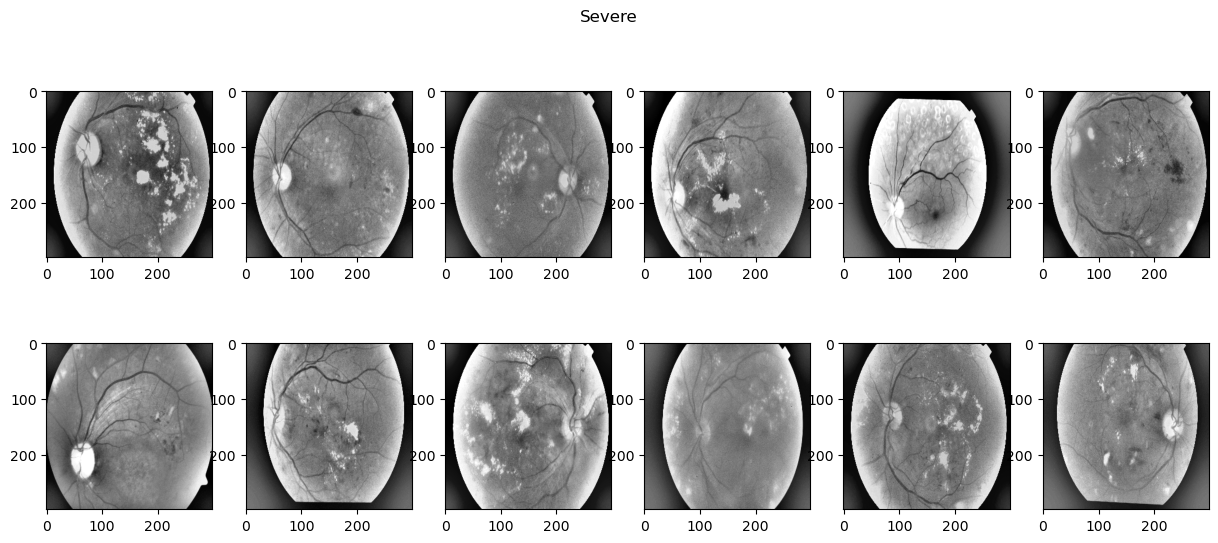

In [28]:
CLASS_ID = 3
draw_img_light(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSES[CLASS_ID])

In [29]:
# Image Croping
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

In [30]:
def crop_image_from_gray(img,tol=7):
    if img.ndim== 2:
        mask=img>tol
    elif img.ndim==3:
        gray_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        mask=gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    
#         check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if check_shape ==0: # Image was full dark and may be cropout everything.
            return img # Return original Image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            print(img1.shape,img2.shape,img3.shape)            
            img=np.stack([img1,img2,img3],axis=1)
            print(img.shape)
            return img

In [31]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)

    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_DIM, IMG_DIM))
    image=cv2.addWeighted( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [61]:
%time

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y_train.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=r"../Users/Sarmita Majumdar/Desktop/HealthCare-Research/aptos2019/Classification/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

CPU times: total: 0 ns
Wall time: 0 ns


ValueError: a must be greater than 0 unless no samples are taken

<Figure size 2500x1600 with 0 Axes>

In [62]:
def crop_image(img,tol=7):
    w, h = img.shape[1],img.shape[0]
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = cv2.blur(gray_img,(5,5))
    shape = gray_img.shape 
    gray_img = gray_img.reshape(-1,1)
    quant = quantile_transform(gray_img, n_quantiles=256, random_state=0, copy=True)
    quant = (quant*256).astype(int)
    gray_img = quant.reshape(shape)
    xp = (gray_img.mean(axis=0)>tol)
    yp = (gray_img.mean(axis=1)>tol)
    x1, x2 = np.argmax(xp), w-np.argmax(np.flip(xp))
    y1, y2 = np.argmax(yp), h-np.argmax(np.flip(yp))
    if x1 >= x2 or y1 >= y2 : # something wrong with the crop
        return img # return original image
    else:
        img1=img[y1:y2,x1:x2,0]
        img2=img[y1:y2,x1:x2,1]
        img3=img[y1:y2,x1:x2,2]
        img4=img[y1:y2,x1:x2,3]
        img = np.stack([img1,img2,img3,img4],axis=-1)
    return img

def process_image(image, size=512):
    image = cv2.resize(image, (size,int(size*image.shape[0]/image.shape[1])))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    try:
        image = crop_image(image, tol=15)
    except Exception as e:
        image = image
        print( str(e) )
    return image

In [76]:
# Display some random images from Data Set with class categories. showig Gray image removing other channel and adding lighting to image.
figure = plt.figure(figsize=(20, 16))
for target_class in (y_train.unique()):
    #     print(CLASSS[target_class],target_class)
    for i, (idx, row) in enumerate(
            df_train.loc[df_train.diagnosis == target_class].sample(5, random_state=SEED).iterrows()):
        ax = figure.add_subplot(5, 5, target_class * 5 + i + 1)
        imagefile = f"../aptos2019/Classification/train_images/{row['id_code']}.png"
        img = cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), IMG_DIM / 10), -4, 128)
        plt.imshow(img, cmap='gray')
        ax.set_title('%s-%d-%s' % (CLASSES[target_class], idx, row['id_code']))
        print(row['id_code'])
        plt.show()

ValueError: a must be greater than 0 unless no samples are taken

<Figure size 2000x1600 with 0 Axes>

##### Data Pre-Processing
Croping Images
https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv

In [79]:
imgPath = f"C:/Users/Sarmita Majumdar/Desktop/HealthCare-Research/aptos2019/train_images/cd54d022e37d.png"
img = cv2.imread(imgPath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
x, y, w, h = cv2.boundingRect(cnt)
img = img[y:y + h, x:x + w]
plt.imshow(img)

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [80]:
### Croping Images randomly for resizing.
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    img = img[y:(y + dy), x:(x + dx), :]
    return img

In [81]:
"""Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """


def crop_generator(batches, crop_length):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[0] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

### Adding image type with image in dataframe


In [82]:
# print("available RAM:", psutil.virtual_memory())
gc.collect()
# print("available RAM:", psutil.virtual_memory())

df_train.id_code = df_train.id_code.apply(lambda x: x + ".png")
df_test.id_code = df_test.id_code.apply(lambda x: x + ".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

##### Image Data Generator
In this section willl use Keras ImageDataGenerator class for generating data for Keras model. It is used for data generation, increasing the data size. with the help of ImageDataGenerator we will do image "augment" via a number of random transformations, so that our model would never see twice the exact same picture.

Training Deep Learning model can perform better with more data, and augementation technique can create variations of data that can increase the ababiliy of fit model to gene

In [83]:
# Creating the imageDatagenerator Instance 
datagenerator=ImageDataGenerator(#rescale=1./255,
#                                       validation_split=0.15, 
                                         horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')

In [85]:
imgPath = f"./Users/Sarmita Majumdar/Desktop/HealthCare-Research/aptos2019/train_images/cf0824f53dd9.png"
# Loading image
img = load_img(imgPath)
data = img_to_array(img)
samples =np.expand_dims(data, 0)
i=5
it=datagenerator.flow(samples , batch_size=1)
for i in range(5):
    plt.subplot(230 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './Users/Sarmita Majumdar/Desktop/HealthCare-Research/aptos2019/train_images/cf0824f53dd9.png'

In [86]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                         validation_split=0.15, 
                                         horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')
# valid_datagen=image.ImageDataGenerator(rescale=1./255)

In [87]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="../aptos2019/Classification/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shaffle=True,
                                                    seed=SEED,
                                                    )
valid_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="../aptos2019/Classification/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shaffle=True,
                                                    seed=SEED
                                                    )
del x_train
# # del x_test
del y_train
# del y_test
gc.collect()
#  color_mode= "grayscale",

Found 0 validated image filenames belonging to 0 classes.


C:\Users\Sarmita Majumdar\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 3662 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames belonging to 0 classes.


C:\Users\Sarmita Majumdar\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 3662 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


1578

### Model Architecture Design

import numpy as np
import psutil
import tensorflow as tf

model = tf.keras.applications.ResNet50()

In [88]:
def design_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=[IMG_DIM, IMG_DIM, CHANNEL_SIZE], activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1000, activation=relu))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1000, activation=relu))
    model.add(Dropout(rate=0.2))
    model.add(Dense(5, activation='softmax'))
    return model

model = design_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 73, 73, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 36, 36, 64)        0

### Compile model

In [89]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

### Keras Callback Funcations
###### Call Back functions Eraly Stoping and Learning Rate Reducing

In [90]:
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

In [91]:
NUB_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUB_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(0, 0)

### Transfer Learning

In [94]:
#from tensorflow.python.keras.applications.resnet50 import ResNet50

def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))
    base_model = ResNet50(weights = None, include_top=False, input_tensor=input_tensor)
    # base_model.load_weights('../HealthCare-Research/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(2048, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)

    return model_resnet



model_resnet = create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)

### To view My model weight structure

In [ ]:
import h5py

for layer in model.layers :
    print(layer.name+" : input ("+str(layer.input_shape)+") output ("+str(layer.output_shape)+")")

print("__")
with h5py.File(weights_filepath, 'r') as f:
    for k in f.keys():
        for l in f[k].keys():
            for m in f[k][l].keys():
                print(k+ " : " + m + " : " + str(f[k][l][m].shape))


In [101]:
for layers in model_resnet.layers:
    layers.trainable = True

In [102]:
learning_rate = 0.001
momentum = 0.9
nesterov = True
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
#model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
#model.summary()
gc.collect()

1876

In [103]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = 2,
        callbacks=[eraly_stop, reduce_lr],
        epochs= 1,
        validation_data=valid_generator,
        validation_steps=20,
        verbose=2
        )
#gc.collect()

C:\Users\Sarmita Majumdar\AppData\Local\Temp\ipykernel_7284\1344686414.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


ValueError: Asked to retrieve element 0, but the Sequence has length 0

### Display Validation Accuracy & Loss

In [97]:
history.history.keys()

NameError: name 'history' is not defined

In [ ]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(accu, label="Accuracy")
plt.plot(accu)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="x", color="r",
         label="best model")
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Validation Accuracy

In [ ]:
from keras.applications import ResNet50

conv_base = ResNet50(weights = 'imagenet',
                 include_top = False,
                 input_shape = (256, 256, 3))

In [ ]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy) = tqdm(
    model_resnet.evaluate_generator(generator=valid_generator, steps=NUB_VALID_STEPS))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2, horizontal_flip=True)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory="../aptos2019/Classification/test_images/",
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  seed=SEED)
# del df_test
print(df_test.shape[0])
# del train_datagen
# del traabsin_generator
gc.collect()

### Test-Time Augmentation
In the below section, we are doning TTA imporving the prediction accuracy. It will transform image and predict

In [ ]:
test_steps = 5
preds_test = []
for i in tqdm(range(test_steps)):
    test_generator.reset()
    preds = model_resnet.predict_generator(generator=test_generator, steps=ceil(df_test.shape[0]))
    #     print('Before ', preds.shape)
    preds_test.append(preds)
#     print(i,  len(preds_tta))

In [ ]:
final_preds = np.mean(preds_test, axis=0)
pred_class_indices = np.argmax(final_preds, axis=1)
len(pred_class_indices)

 del valid_generator
gc.collect()
 test_generator.reset()

 pred=model.predict_generator(test_generator, verbose=0, steps=STEP_SIZE_TEST)
 predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
# test_generator.filenames.apply(lambda x: x[-4])
results = pd.DataFrame({"id_code": test_generator.filenames, "diagnosis": pred_class_indices})
results.id_code = results.id_code.apply(lambda x: x[:-4])  # results.head()
results.to_csv("diabetic_ret.csv", index=False)

### Visualization Test Result
this section will visualize the predicted classes of test data.

In [ ]:
results['diagnosis'].value_counts().plot(kind='bar')
plt.title('Test Samples Per Class')